# Image Classification Train Model

#### Project Url: https://github.com/akshath/image_classification_kit_keras

In [1]:
#---- Install stuff -------
!pip install --upgrade pip

!pip install tensorflow
!pip install numpy==1.19.5

!pip install Pillow
!pip install playsound
!pip install gTTS

!pip install matplotlib
!pip install pandas
!pip install seaborn

!pip install PyYAML

In [1]:
import pathlib

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import os
import PIL
import zipfile

from PIL import Image

In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

In [3]:
#from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.resnet_v2 import ResNet50V2

In [4]:
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [13]:
is_google_colab = False
is_azure_ml = False

In [14]:
print('tf version: ',tf.__version__)
print('keras version: ',keras.__version__)

tf version:  2.6.0
keras version:  2.6.0


In [15]:
#check for GPU
#print('tf gpu: ',tf.test.is_gpu_available())
print('tf gpu: ',tf.config.list_physical_devices('GPU'))
for x in tf.config.list_physical_devices():
    print('device: ',x)

tf gpu:  []
device:  PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')


In [16]:
import FileIOUtil
import TTSUtil
from ImageClassificationCfg import ImageClassificationCfg
from RandomColorDistortion import RandomColorDistortion

# Read Cfg

In [47]:
import os

In [ ]:
if os.name == 'nt':
    !cd
    !dir
else:
    !pwd
    !ls

In [18]:
cfg_file = './project/flowers-recognition.yml'
#cfg_file = './project/work_pose.yml'
#cfg_file = './project/home_presence.yml'

cfg_file = ImageClassificationCfg(cfg_file)
cfg_file.load()

In [11]:
if os.path.isdir(cfg_file.cfg["project_parent_dir"])==False:
    os.mkdir(cfg_file.cfg["project_parent_dir"])
if os.path.isdir(cfg_file.project_dir)==False:
    os.mkdir(cfg_file.project_dir)

In [19]:
## If you are using the data by mounting the google drive, use the following :
if is_google_colab:
    from google.colab import drive
    drive.mount('/content/gdrive')
##Ref:https://towardsdatascience.com/downloading-datasets-into-google-drive-via-google-colab-bcb1b30b0166

In [20]:
working_dir_str = cfg_file.project_dir

In [22]:
#!ls $working_dir_str
FileIOUtil.print_dir(working_dir_str, only_dir=True)

./project/flowers-recognition/daisy
./project/flowers-recognition/dandelion
./project/flowers-recognition/rose
./project/flowers-recognition/sunflower
./project/flowers-recognition/tulip


In [44]:
#path_to_zip_file = '/content/gdrive/MyDrive/ColabNotebooks/flowers-recognition.zip'
#path_to_zip_file = '/content/gdrive/MyDrive/ColabNotebooks/work_pose.zip'
path_to_zip_file = '/content/gdrive/MyDrive/ColabNotebooks/home_presence.zip'
!ls $path_to_zip_file

ls: /content/gdrive/MyDrive/ColabNotebooks/home_presence.zip: No such file or directory


In [20]:
#already_extracted = False
already_extracted = False if len(FileIOUtil.get_dir(working_dir_str))==0 else True
print('already_extracted: ',already_extracted)
if already_extracted==False:  
    with zipfile.ZipFile(path_to_zip_file, 'r') as zip_ref:
        zip_ref.extractall(working_dir_str)

already_extracted:  True


In [23]:
#!ls $working_dir_str
FileIOUtil.print_dir(working_dir_str, only_dir=True)

./project/flowers-recognition/daisy
./project/flowers-recognition/dandelion
./project/flowers-recognition/rose
./project/flowers-recognition/sunflower
./project/flowers-recognition/tulip


In [50]:
if os.name == 'nt':
    !rmdir /Q /S \'$working_dir_str'__MACOSX'\'
else:
    !rm -r $working_dir_str'__MACOSX'

The system cannot find the path specified.


In [28]:
rand_seed = 30
np.random.seed(rand_seed)
import random as rn
rn.seed(rand_seed)
tf.random.set_seed(rand_seed)

# Create Data Set

In [26]:
batch_size = 20

color_mode="rgb"
#color_mode="grayscale"

In [25]:
print('working_dir_str: ', working_dir_str)
#!ls $working_dir_str
FileIOUtil.print_dir(working_dir_str, only_dir=True)

working_dir_str:  ./project/flowers-recognition/
./project/flowers-recognition/daisy
./project/flowers-recognition/dandelion
./project/flowers-recognition/rose
./project/flowers-recognition/sunflower
./project/flowers-recognition/tulip


In [29]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    working_dir_str, 
    label_mode='categorical',
    batch_size=batch_size, image_size=(cfg_file.cfg['input_img_height'], cfg_file.cfg['input_img_width']), 
    shuffle=True, 
    seed=rand_seed, validation_split=0.2, subset='training', color_mode=color_mode
)

Found 4317 files belonging to 5 classes.
Using 3454 files for training.


In [30]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    working_dir_str, 
    label_mode='categorical',
    batch_size=batch_size, image_size=(cfg_file.cfg['input_img_height'], cfg_file.cfg['input_img_width']), 
    shuffle=True, 
    seed=rand_seed, validation_split=0.2, subset='validation', color_mode=color_mode
)

Found 4317 files belonging to 5 classes.
Using 863 files for validation.


In [31]:
class_names = train_ds.class_names
print(class_names)

['daisy', 'dandelion', 'rose', 'sunflower', 'tulip']


In [32]:
num_classes = len(train_ds.class_names)
num_classes

5

### Visualize the data

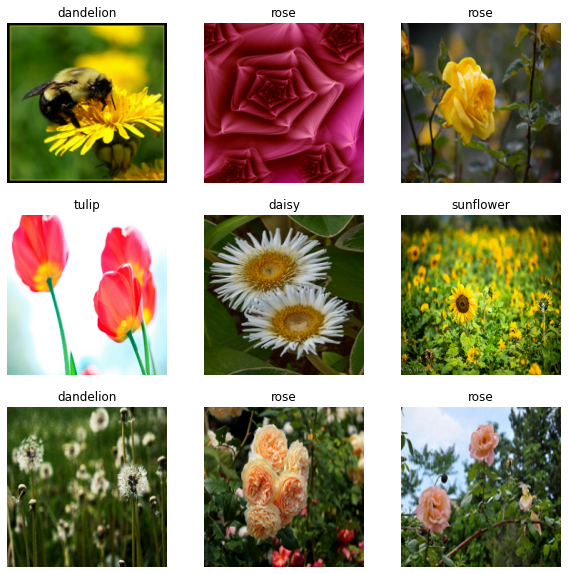

In [33]:
#see few sample images
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(3*3):
        ax = plt.subplot(3, 3, i + 1)
        if color_mode=="grayscale":      
            plt.imshow(images[i].numpy().astype("uint8")[:, :, 0], cmap='gray') #
        else:
            plt.imshow(images[i].numpy().astype("uint8"))
        score = tf.nn.softmax(labels[i])
        class_i = np.argmax(score)
        plt.title( class_names[class_i] )
        plt.axis("off")
plt.show()

In [34]:
for image_batch, labels_batch in train_ds:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

(20, 224, 224, 3)
(20, 5)


In [35]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Data Augumentation

In [36]:
print('input_img_height:',cfg_file.cfg['input_img_height'],)
print('input_img_width:',cfg_file.cfg['input_img_width'])

input_img_height: 224
input_img_width: 224


In [37]:
#reload cfg
#cfg_file.load()

In [38]:
#https://towardsdatascience.com/writing-a-custom-data-augmentation-layer-in-keras-2b53e048a98
randomColorDistortion = RandomColorDistortion()
randomColorDistortion.update_cfg(cfg_file)

data_augmentation = Sequential(
    [
        layers.experimental.preprocessing.RandomRotation(
            tuple(cfg_file.cfg['train_augumentation']['random_rotation']),#(-0.03,0.03), #3% random rotation        
            input_shape=(cfg_file.cfg['input_img_height'], cfg_file.cfg['input_img_width'], 1 if color_mode=="grayscale" else 3)), 
        
        layers.experimental.preprocessing.RandomZoom(
            tuple(cfg_file.cfg['train_augumentation']['random_zoom']) #(-0.05,0)  #5% random zoom-in
        ),
        
        randomColorDistortion,
    ])

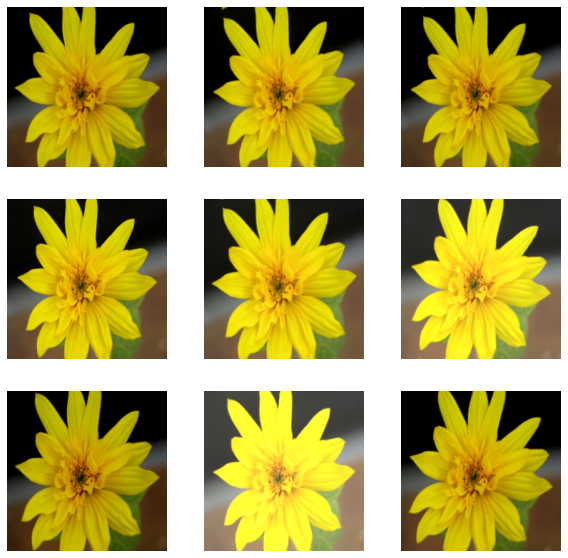

In [39]:
# visualize how your augmentation strategy works for one instance of training image.
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    img_index = 1
    for i in range(3*3):
        augmented_images = data_augmentation(images, training=True)
        ax = plt.subplot(3, 3, i + 1)
        if color_mode=="grayscale":      
            plt.imshow(augmented_images[img_index].numpy().astype("uint8")[:, :, 0], cmap='gray') #
        else:
            plt.imshow(augmented_images[img_index].numpy().astype("uint8"))
        plt.axis("off")
plt.show()

# Model

In [40]:
filepath = cfg_file.cfg['model_file']
print('filepath:',filepath)
print('train_freeze_base_layer: ', cfg_file.cfg['train_freeze_base_layer'])
print('train_freeze_skip_last_layers: ', cfg_file.cfg['train_freeze_skip_last_layers'])

filepath: ./project/model_files/flowers_recognition_model.h5
train_freeze_base_layer:  True
train_freeze_skip_last_layers:  4


In [41]:
# Callbacks

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', save_freq="epoch")

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.75, patience=4, cooldown=1) # write the REducelronplateau code here

ES = EarlyStopping(monitor='val_loss', patience=15, verbose=1, mode="auto")

callbacks_list = [checkpoint, LR, ES]

In [42]:
model_to_try = 2 #base cnn
#model_to_try = 2 #transfer learning cnn

print('model_to_try: ', model_to_try)

model_to_try:  1


In [ ]:
if model_to_try==1:
    #model - bare cnn
    cnn_model = Sequential([
        data_augmentation, 
        #tf.keras.layers.experimental.preprocessing.Rescaling(1./255),
        tf.keras.layers.experimental.preprocessing.Normalization(), 

        Conv2D(16, (3, 3), padding='same', activation='relu'),
        MaxPooling2D(pool_size=(2, 2)),
        BatchNormalization(),

        Conv2D(32, (3, 3), padding='same', activation='relu'),
        MaxPooling2D(pool_size=(2, 2)),
        BatchNormalization(),

        Conv2D(64, (3, 3), padding='same', activation='relu'),
        MaxPooling2D(pool_size=(2, 2)),
        BatchNormalization(),

        Conv2D(128, (3, 3), padding='same', activation='relu'),
        MaxPooling2D(pool_size=(2, 2)),
        BatchNormalization(),

        Flatten(),

        Dense(64, activation='relu'),
        Dropout(0.50),
        BatchNormalization(),

        Dense(64, activation='relu'),
        Dropout(0.50),
        BatchNormalization(),

        Dense(num_classes, activation='softmax')])

In [ ]:
#model - transfer learning
if model_to_try==2:
    conv_base = ResNet50V2(
        include_top=False,
        weights='imagenet',
        input_shape=(cfg_file.cfg['input_img_height'], cfg_file.cfg['input_img_width'], 1 if color_mode=="grayscale" else 3))

    if cfg['train_freeze_base_layer']:
        # freeze all the weights of the model except the last 4 layers
        for layer in conv_base.layers[:cfg['train_freeze_skip_last_layers']*-1]:
            layer.trainable = False

    cnn_model = Sequential([
        data_augmentation, 
        #tf.keras.layers.experimental.preprocessing.Rescaling(1./255),
        tf.keras.layers.experimental.preprocessing.Normalization(), 
        conv_base, 

        #MaxPooling2D(pool_size=(2, 2)),
        GlobalAveragePooling2D(),
        Flatten(),
        BatchNormalization(),

        #--- s --
        Dense(256, activation='relu'),
        Dropout(0.50),#40
        BatchNormalization(),

        Dense(128, activation='relu'),
        Dropout(0.50),#40
        BatchNormalization(),

        Dense(64, activation='relu'),
        Dropout(0.50),#40
        BatchNormalization(),
        #--- s --

        #--- l --
        #Dense(512, activation='relu'),
        #Dropout(0.60),#40
        #BatchNormalization(),

        #Dense(256, activation='relu'),
        #Dropout(0.60),
        #BatchNormalization(),

        #Dense(128, activation='relu'),
        #Dropout(0.60),
        #BatchNormalization(),

        #Dense(64, activation='relu'),
        #Dropout(0.10),
        #BatchNormalization(),
        #--- l --

        Dense(num_classes, activation='softmax')
        ])

In [ ]:
lr = 0.0001
optimiser = keras.optimizers.Adam(learning_rate=lr)
cnn_model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['accuracy'])
print (cnn_model.summary())

In [ ]:
### Train the model
epochs = 50
history = cnn_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    callbacks=callbacks_list,
    initial_epoch = 0
)

### Visualizing training results

In [ ]:
# Visualizing training results
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

#epochs_range = range(num_epochs)
epochs_range = range(len(val_acc))

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [43]:
TTSUtil.speak('We got validation accuracy of '+str(round(history.history['val_accuracy'][-1]*100,2)), ipython=True)

NameError: name 'history' is not defined

In [ ]:
#save json model file also
from keras.models import model_from_json

model_json = cnn_model.to_json()
#print('model_json: ',model_json)

with open(project_name+".json", "w") as json_file:
    json_file.write(model_json)

In [ ]:
#copy model file
if is_google_colab:
    !cp $filepath '/content/gdrive/MyDrive/ColabNotebooks/'

In [ ]:
#todo add code to see what failed most
#run through val set and log case wise no and accuracy and log image of good and bad